# CS:GO Round Winner Prediction
This dataset is obtained from: https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification

## Table of contents
- [Introduction](#1)
- [Imports](#2)
- [Exploratory Data Analysis](#3)
- [Pre-Processing and Transformation](#4)
- [Fitting Models](#5)
    - [Logistic Regression](#5.1)
    - [Random Forest](#5.2)
    - [Neural Network](#5.3)
    - [Summary](#5.4)
- [Dimension Reduction](#6)
    - [PCA](#6.1)
    - [Truncated SVD](#6.2)
    - [Comparison](#6.3)
- [Conclusion](#7)

## Introduction  <a name="1"></a>

CS:GO is a tactical shooter where two teams, Terrorist and Counter-Terrorist, play for a best of 30 rounds. Terrorist can win by either planting the bomb and making sure it explodes, or by eliminating the other team. To learn more about CS:GO, please check out this link https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive <br>

This project uses snapshot of each rounds to predict the winner of the round. The snapshot is recorded every 20 seconds since the round start until the round is decided. Each record contains information such as previous rounds' winner, remaining time of the round, each teams' HP and equipment, etc.

In the project, I trained and tuned a logistic regression model, a random forest model, and a shadow neural network model and compared their performance. In addition, I used PCA and truncated SVD for dimension reduction in attempts to reduce model execution time without d.

## Imports  <a name="2"></a>

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, lognorm, loguniform, randint

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
dataset = pd.read_csv('csgo_round_snapshots.csv', delimiter = ',')
dataset

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T


## Exploratory Data Analysis  <a name="3"></a> 
We will first try to understand the dataset by performing EDA

| Variable | Definition |
| --- | --- |
time_left	| The time left in the current round.	
ct_score	| The current score of the Counter-Terrorist team.	
t_score	|The current score of the Terrorist team.	
map	| The map the round is being played on.
bomb_planted |	If the bomb has been planted or not.	False = No, True = Yes
ct_health | The total health of all Counter-Terrorist players.	Player health in range 0-100.
t_health | The total health of all Terrorist players.	Player health in range 0-100.
ct_armor | The total armor of all Counter-Terrorist players.	
t_armor | The total armor of all Terrorist players.	
ct_money | The total bankroll of all Counter-Terrorist players.	Amount in USD.
t_money | The total bankroll of all Terrorist players.	Amount in USD.
ct_helmets | Number of helmets on the Counter-Terrorist team.	
t_helmets | Number of helmets on the Terrorist team.	
ct_defuse_kits | Number of defuse kits on the Counter-Terrorist team.	
ct_players_alive | Number of alive players on the Counter-Terrorist team.	Range 0 to 5.
t_players_alive | Number of alive players on the Terrorist team.	Range 0 to 5.
ct_weapon_X | Weapon X count on Counter-Terrorist team.	E.g. Ak47, Deagle and UMP45.
t_weapon_X | Weapon X count on Terrorist team.	E.g. Ak47, Deagle and UMP45.
ct_grenade_X |Grenade X count on Counter-Terrorist team.	E.g. HeGrenade, Flashbang.
t_grenade_X |Grenade X count on Terrorist team.	E.g. HeGrenade, Flashbang.
round_winner | Winner.	CT = Counter-Terrorist, T = Terrorist


In [3]:
dataset.shape

(122410, 97)

We can see that, apart from round_winner, there are 96 features in the dataset, and 80 of them are related to players' weaponries weapon_X/grenade_X. Let's first focused on the non-weaponries features.

In [4]:
non_weaponry_columns = [
                        'time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health', 't_health', 'ct_armor', 't_armor', 
                        'ct_money', 't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
                        'round_winner'
]

dataset_non_weaponry = dataset[ non_weaponry_columns ]

dataset_non_weaponry.shape

(122410, 17)

In [5]:
dataset_non_weaponry['round_winner'].value_counts(normalize=True)

T     0.509811
CT    0.490189
Name: round_winner, dtype: float64

There is no strong class imbalance issue in terms of the output.

In [6]:
dataset_non_weaponry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time_left         122410 non-null  float64
 1   ct_score          122410 non-null  float64
 2   t_score           122410 non-null  float64
 3   map               122410 non-null  object 
 4   bomb_planted      122410 non-null  bool   
 5   ct_health         122410 non-null  float64
 6   t_health          122410 non-null  float64
 7   ct_armor          122410 non-null  float64
 8   t_armor           122410 non-null  float64
 9   ct_money          122410 non-null  float64
 10  t_money           122410 non-null  float64
 11  ct_helmets        122410 non-null  float64
 12  t_helmets         122410 non-null  float64
 13  ct_defuse_kits    122410 non-null  float64
 14  ct_players_alive  122410 non-null  float64
 15  t_players_alive   122410 non-null  float64
 16  round_winner      12

We observe that there are 15 attributes. 2 of them are categorical and 13 of them are numerical <br>
None of them has missing value, so imputation is not needed. <br>

In [7]:
dataset_non_weaponry.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,2.773638,1.613724,4.273752,4.266187
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,2.010915,1.605780,1.205500,1.228325
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,0.000000,0.000000,4.000000,4.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,3.000000,1.000000,5.000000,5.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,5.000000,3.000000,5.000000,5.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,5.000000,5.000000,5.000000,6.000000


The range of the attributes different from one other. For example, the range for ct_money and t_money is \[0, 80000\] whereas that for ct_helmets and t_helmets is \[0, 5\] <br>
Standardization might be needed to improve the performance of some models. <br>
There also seems to be no outliers.

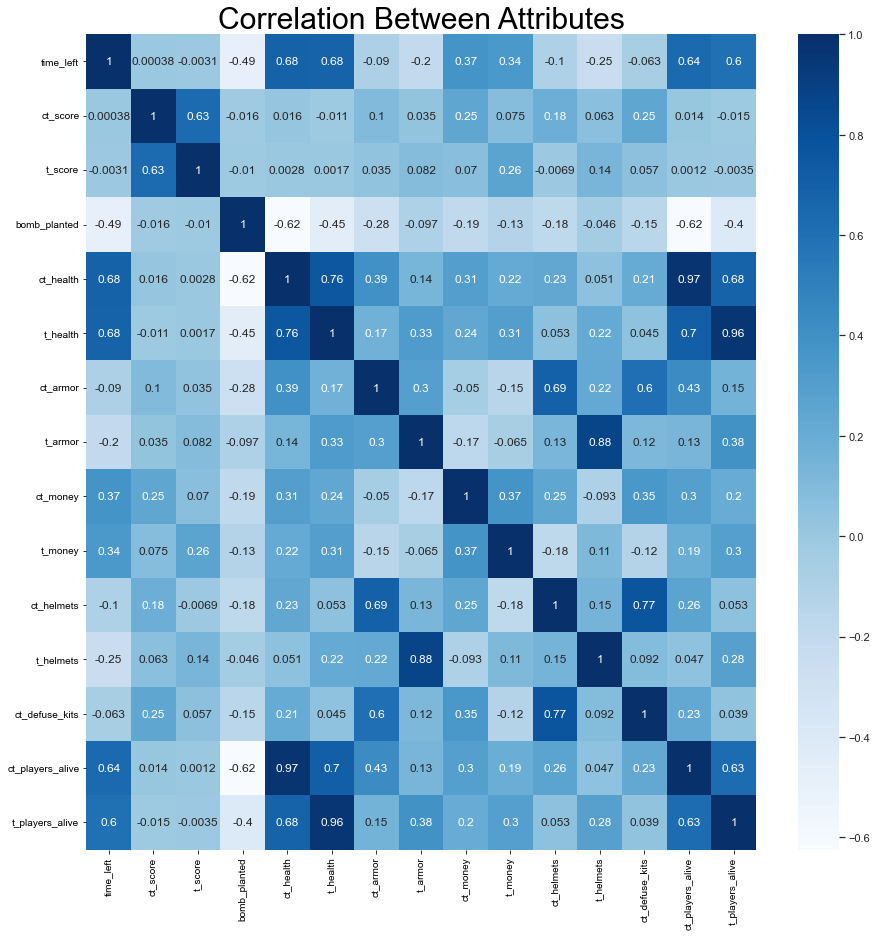

In [8]:
cor = dataset_non_weaponry.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlation Between Attributes', fontsize=30)
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Health has high correlation with players_alive (0.96 for t and 0.97 for ct). This is reasonable because the more players a team has, the more its total health is likely to be. <br>
We can remove players_alive to reduce the co-linearity issue. <br>

There is also moderate correlation between t_health and ct_health, time_left and health. However, they reflects different properties, and they seem to be crucial for making predictions. So, let's keep them for now.

array([[<AxesSubplot:title={'center':'time_left'}>,
        <AxesSubplot:title={'center':'ct_score'}>,
        <AxesSubplot:title={'center':'t_score'}>,
        <AxesSubplot:title={'center':'ct_health'}>],
       [<AxesSubplot:title={'center':'t_health'}>,
        <AxesSubplot:title={'center':'ct_armor'}>,
        <AxesSubplot:title={'center':'t_armor'}>,
        <AxesSubplot:title={'center':'ct_money'}>],
       [<AxesSubplot:title={'center':'t_money'}>,
        <AxesSubplot:title={'center':'ct_helmets'}>,
        <AxesSubplot:title={'center':'t_helmets'}>,
        <AxesSubplot:title={'center':'ct_defuse_kits'}>],
       [<AxesSubplot:title={'center':'ct_players_alive'}>,
        <AxesSubplot:title={'center':'t_players_alive'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

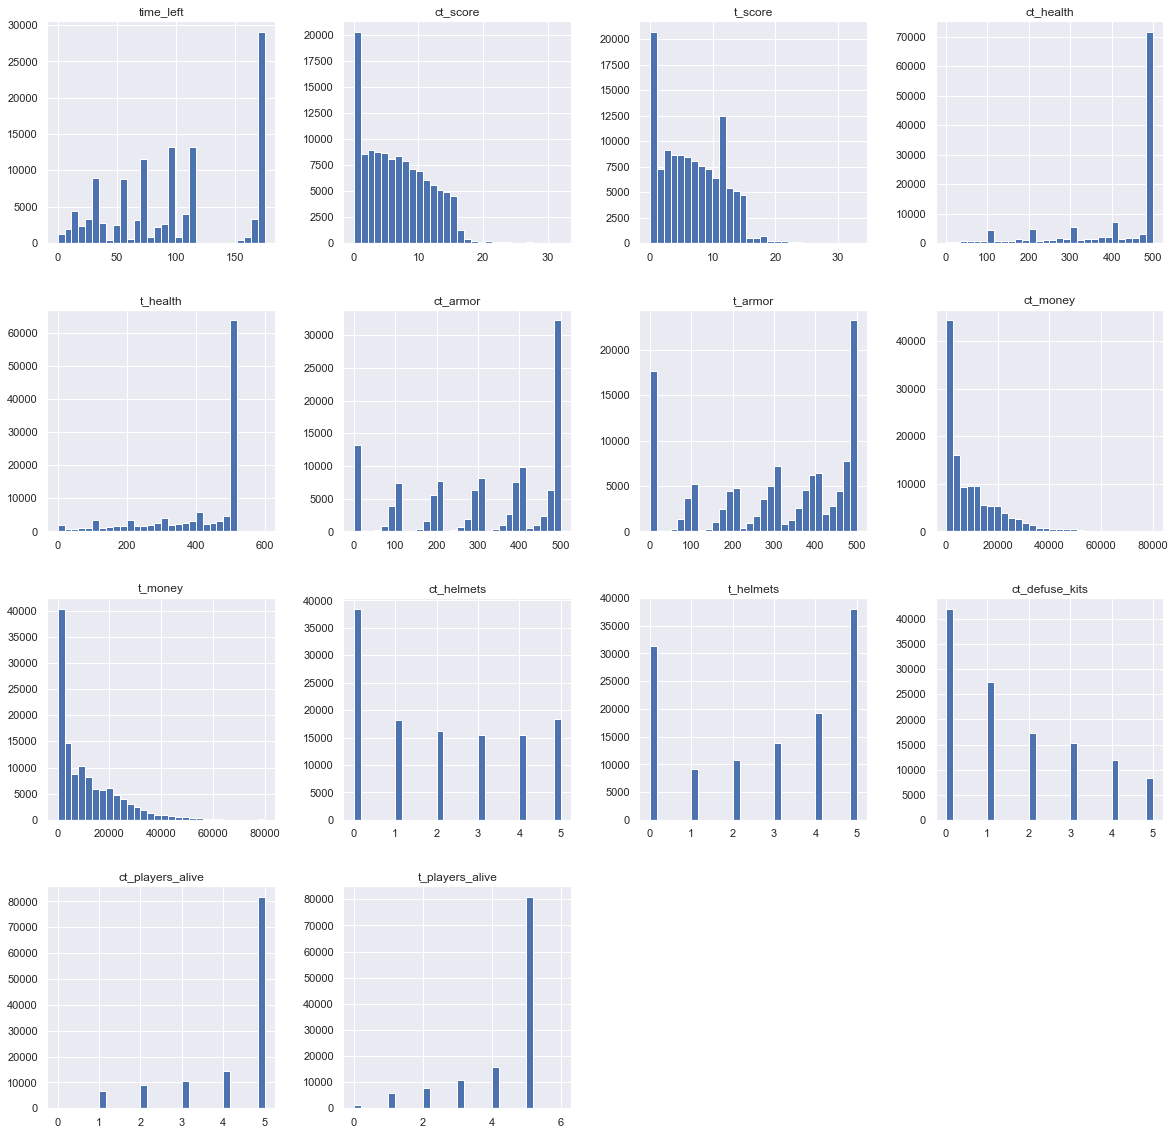

In [9]:
dataset_non_weaponry.hist(figsize=(20, 20), bins=30)

<AxesSubplot:xlabel='round_winner', ylabel='count'>

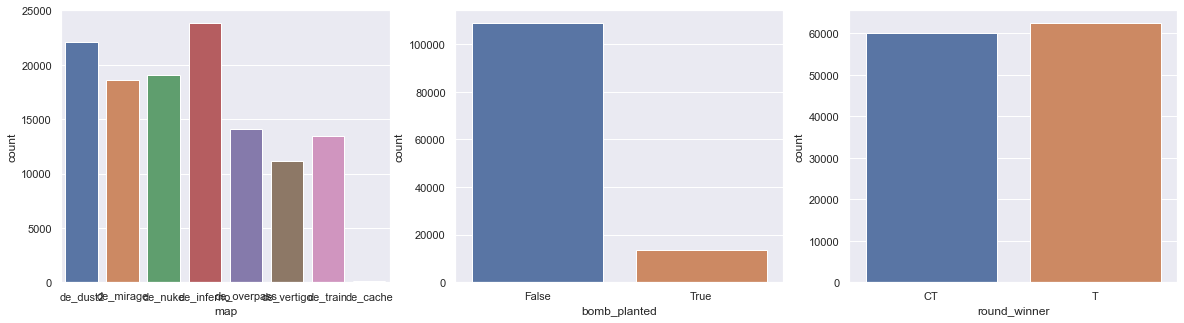

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x=dataset_non_weaponry['map'], ax=axes[0])
sns.countplot(x=dataset_non_weaponry['bomb_planted'], ax=axes[1])
sns.countplot(x=dataset_non_weaponry['round_winner'], ax=axes[2])

In [11]:
dataset_non_weaponry['bomb_planted'].value_counts(normalize=True)

False    0.888212
True     0.111788
Name: bomb_planted, dtype: float64

Majority of bomb_planted is False. We may need to consider give larger weight on samples with bomb_planted = True.

For weaponry-related feature:

In [12]:
pd.options.display.max_columns = None
dataset_weaponry = dataset.drop(columns=non_weaponry_columns)
dataset_weaponry.describe()

,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,0.274602,1.243926,0.134613,0.007638,0.573695,0.321191,0.0,0.000082,0.151989,0.106053,0.004011,0.001773,0.110138,0.004738,0.0,0.000792,0.011045,0.110301,0.006919,3.310195,0.000008,0.0,0.063818,0.002729,1.076236,0.052733,0.007557,0.107311,0.004403,0.000049,0.001462,0.002753,0.002034,0.001952,0.146998,0.005645,0.0,0.000008,0.000980,0.000106,0.000163,0.000155,0.0,0.000057,0.0,0.000139,0.000719,0.000008,0.239147,0.824941,0.059505,0.020440,0.046426,0.036468,0.007557,0.000261,0.440675,0.380868,0.061751,0.009386,3.179789,0.122400,0.236974,0.291618,0.174046,0.004934,0.008120,0.028323,0.899101,0.438257,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,0.584092,1.363887,0.460303,0.091456,0.673249,0.476667,0.0,0.009038,0.445910,0.379993,0.063206,0.042067,0.388980,0.070780,0.0,0.037148,0.112130,0.405933,0.086935,1.625785,0.002858,0.0,0.262884,0.053096,1.219112,0.247009,0.094191,0.411783,0.067433,0.007001,0.038212,0.054386,0.045775,0.044695,0.472347,0.081602,0.0,0.002858,0.031295,0.010305,0.012781,0.012458,0.0,0.007562,0.0,0.011784,0.026803,0.002858,0.554073,1.139545,0.264790,0.146044,0.230066,0.211221,0.088096,0.016166,0.834516,0.814730,0.288498,0.100087,1.586788,0.438928,0.533787,0.579258,0.425142,0.074807,0.094879,0.191538,1.281569,0.808149,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000

The data is sparse with no missing values and outliers. <br> 
Some columns, including ct_weapon_bizon, ct_weapon_g3sg1, t_weapon_m249, ct_weapon_negev, ct_weapon_r8revolver, ct_weapon_sawedoff, are always 0.

To summarize our observations:
- There is no strong class imbalance issue in terms of the output.
- The range of the attributes different from one other.
- There is high correlation between health and players_alive.
- Majority (88.8%) of the samples have bomb_planted = False. 
- We have 96 features in total. Some model could suffer from the high dimensionality

## Pre-Processing and Transformation <a name="4"></a> 
We will do preprocessing separately for the complete dataset and the dataset after PCA.

In [13]:
y = dataset[['round_winner']]
X = dataset.drop(columns='round_winner')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
X_train.shape

(97928, 96)

In [15]:
y_train.shape

(97928, 1)

In [16]:
y_train = y_train.replace({'CT':1, 'T': 0})
y_test = y_test.replace({'CT':1, 'T': 0})
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [17]:
drop_features = ['ct_players_alive', 't_players_alive', 'ct_weapon_bizon', 'ct_weapon_g3sg1', 't_weapon_m249', 
                 'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff']
binary_features = ['bomb_planted']
nominal_features=['map']

# used for-loop to keep the order of features for better readability
numeric_features = []
for col in X.columns:
    if col in set(X.columns) - set(drop_features) - set(binary_features) - set(nominal_features):
        numeric_features.append(col)

In [18]:
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), nominal_features),
) 

preprocessor

ColumnTransformer(transformers=[('drop', 'drop',
                                 ['ct_players_alive', 't_players_alive',
                                  'ct_weapon_bizon', 'ct_weapon_g3sg1',
                                  't_weapon_m249', 'ct_weapon_negev',
                                  'ct_weapon_r8revolver',
                                  'ct_weapon_sawedoff']),
                                ('standardscaler', StandardScaler(),
                                 ['time_left', 'ct_score', 't_score',
                                  'ct_health', 't_health', 'ct_armor',
                                  't_armor', 'ct_money', 't_money',
                                  'ct_helmets', 't...
                                  't_weapon_bizon', 'ct_weapon_cz75auto',
                                  't_weapon_cz75auto', 'ct_weapon_elite',
                                  't_weapon_elite', 'ct_weapon_famas',
                                  't_weapon_famas', 't_weapon_g3sg1',

In [19]:
transformed = preprocessor.fit_transform(X_train, y_train)
transformed.shape

(97928, 95)

In [20]:
## The below code is adopted from stackoverflow and modified for our use.
## It extracts all feature labels after tranformation
## original post: https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names_out'):
        return estimator.get_feature_names_out(feature_in)
    else:
        return feature_in


def get_feature_names_from_column_transformer(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name=='drop':
            pass
        elif name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features


feature_names = get_feature_names_from_column_transformer(preprocessor)

In [21]:
pd.DataFrame(transformed, 
             columns=get_feature_names_from_column_transformer(preprocessor)).describe().round(3)

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,bomb_planted_True,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
count,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.00,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.00,97928.0,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000,97928.000
mean,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.00,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.00,0.0,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.112,0.001,0.182,0.195,0.152,0.155,0.115,0.109,0.090
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.00,0.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.315,0.034,0.386,0.396,0.359,0.362,0.319,0.312,0.287
min,-1.798,-1.402,-1.408,-3.112,-2.880,-1.834,-1.707,-0.874,-0.926,-1.113,-1.377,-1.005,-0.470,-0.912,-0.292,-0.084,-0.852,-0.675,-0.009,-0.340,-0.279,-0.064,-0.042,-0.282,-0.067,-0.021,-0.10,-0.271,-0.080,-2.043,-0.003,-0.241,-0.051,-0.883,-0.215,-0.080,-0.260,-0.066,-0.008,-0.038,-0.050,-0.045,-0.044,-0.310,-0.07,0.0,-0.031,-0.010,-0.013,-0.013,-0.007,-0.012,-0.027,-0.0

## Fitting Models <a name="5"></a> 

We will now start to fit models. We will use precision, recall, f1 score, and accuracy to measure the models' performance. The function below calculates the mean and std of the 4 metrics from cross validation.

In [22]:
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'accuracy': 'accuracy'
}

def mean_std_cross_val_scores(model, X_train, y_train, scoring=scoring, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, scoring=scoring, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.5f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

models={}

### Logistic Regression <a name="5.1"></a> 

In [23]:
logistic = { }

lr = make_pipeline(
    preprocessor, 
    LogisticRegression(max_iter=5000, random_state=1)
)

logistic['default'] = mean_std_cross_val_scores(lr, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(logistic)

,default
fit_time,1.08777 (+/- 0.030)
score_time,0.05884 (+/- 0.002)
test_precision,0.73770 (+/- 0.002)
train_precision,0.73903 (+/- 0.001)
test_recall,0.75425 (+/- 0.007)
train_recall,0.75480 (+/- 0.001)
test_f1,0.74586 (+/- 0.003)
train_f1,0.74683 (+/- 0.000)
test_accuracy,0.74812 (+/- 0.002)
train_accuracy,0.74921 (+/- 0.001)


Logistic regression with default parameters achieved 74.8% in test accuracy, 73.7% in test precision, 75.4% in test recall, and 74.6% in test f1. <br>
There is no over-fitting issue. <br>
Let's try to improve its performance by tuning the hyperparameters. I used accuracy scoring here as our optimization goal because there is no strong class imbalance. 

In [24]:
# param_grid = {
#     'logisticregression__C': loguniform(1e-3, 1e3),
#     'logisticregression__solver':  ['liblinear', 'lbfgs', 'newton-cg'],
# }

# random_search = RandomizedSearchCV(
#     lr,
#     param_grid,
#     n_iter=500,
#     verbose=1,
#     n_jobs=-1,
#     scoring='accuracy',
#     random_state=1,
#     return_train_score=True,
# )

# random_search.fit(X_train, y_train)

In [25]:
# random_search.best_params_

In [26]:
# random_search.best_score_

In [27]:
lr_tuned = make_pipeline(
    preprocessor, 
    LogisticRegression(max_iter=5000, random_state=1, C=0.001910974221528526, solver='lbfgs')
)

logistic['tuned'] = mean_std_cross_val_scores(lr_tuned, X_train, y_train, cv=5, return_train_score=True)
models['logistic'] = logistic['tuned']
pd.DataFrame(logistic)

,default,tuned
fit_time,1.08777 (+/- 0.030),0.55002 (+/- 0.016)
score_time,0.05884 (+/- 0.002),0.05904 (+/- 0.002)
test_precision,0.73770 (+/- 0.002),0.73981 (+/- 0.003)
train_precision,0.73903 (+/- 0.001),0.74049 (+/- 0.001)
test_recall,0.75425 (+/- 0.007),0.75394 (+/- 0.008)
train_recall,0.75480 (+/- 0.001),0.75413 (+/- 0.002)
test_f1,0.74586 (+/- 0.003),0.74678 (+/- 0.003)
train_f1,0.74683 (+/- 0.000),0.74725 (+/- 0.001)
test_accuracy,0.74812 (+/- 0.002),0.74945 (+/- 0.002)
train_accuracy,0.74921 (+/- 0.001),0.74998 (+/- 0.001)


There is no significant improvement after tunning. <br>
It seems more complex models are needed.

### Random Forest <a name="5.2"></a> 

In [28]:
forest_models = {}

rf = make_pipeline(
    preprocessor, 
    RandomForestClassifier(random_state=1)
)

forest_models['default'] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(forest_models)

,default
fit_time,15.17162 (+/- 0.096)
score_time,0.56042 (+/- 0.014)
test_precision,0.86043 (+/- 0.004)
train_precision,0.99721 (+/- 0.000)
test_recall,0.86769 (+/- 0.006)
train_recall,0.99713 (+/- 0.000)
test_f1,0.86403 (+/- 0.002)
train_f1,0.99717 (+/- 0.000)
test_accuracy,0.86617 (+/- 0.001)
train_accuracy,0.99723 (+/- 0.000)


Random forest with default parameter achieves 99.7 in terms of train accuracy. It could be difficult to improve further. However, the validation accuracy is 86.6%. The model has overfits. <br> 
I will next tune the hyper-parameters to improve performance and reduce the overfit.

In [29]:
# param_grid = {
#     'randomforestclassifier__n_estimators': range(10,300),
#     'randomforestclassifier__max_depth': range(5,30),
#     'randomforestclassifier__criterion': ['gini', 'entropy'],
#     'randomforestclassifier__max_features':  ['sqrt', 'log2']
# }

# random_search = RandomizedSearchCV(
#     rf,
#     param_grid,
#     n_iter=500,
#     verbose=2,
#     n_jobs=-1,
#     scoring='accuracy',
#     random_state=1,
#     return_train_score=True,
# )

# random_search.fit(X_train, y_train)

In [30]:
# random_search.best_params_

In [31]:
# random_search.best_score_

In [32]:
rf_tuned = make_pipeline(
    preprocessor, 
    RandomForestClassifier(
        criterion='entropy',
        max_depth=29,
        max_features='log2',
        n_estimators=288,
        random_state=1
    )
)

forest_models['tuned'] = mean_std_cross_val_scores(rf_tuned, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(forest_models)

,default,tuned
fit_time,15.17162 (+/- 0.096),35.78403 (+/- 0.361)
score_time,0.56042 (+/- 0.014),1.43878 (+/- 0.018)
test_precision,0.86043 (+/- 0.004),0.85390 (+/- 0.006)
train_precision,0.99721 (+/- 0.000),0.99603 (+/- 0.001)
test_recall,0.86769 (+/- 0.006),0.88004 (+/- 0.006)
train_recall,0.99713 (+/- 0.000),0.99670 (+/- 0.001)
test_f1,0.86403 (+/- 0.002),0.86674 (+/- 0.001)
train_f1,0.99717 (+/- 0.000),0.99637 (+/- 0.000)
test_accuracy,0.86617 (+/- 0.001),0.86738 (+/- 0.002)
train_accuracy,0.99723 (+/- 0.000),0.99644 (+/- 0.000)


The model's performance improved only slightly (less than 0.2%), and the overfit problem still persists. Another thing that can reduce overfit is min_samples_split, but this is likely to reduce the train/validation accuracy. I'll construct a plot of accuracy against min_samples_split to pick the best value.

In [33]:
# samples = list(range(1,10)) + list(range(10, 101, 10))

# chosen_min_samples_leaf = []
# test_scores = []
# train_scores = []
# for s in samples:
#     rf = make_pipeline(
#         preprocessor, 
#         RandomForestClassifier(
#         criterion='entropy',
#         max_depth=29,
#         max_features='log2',
#         n_estimators=288,
#         min_samples_leaf=s,   
#         random_state=1
#         )
#     )
#     score = cross_validate(rf, X_train, y_train, scoring='accuracy', return_train_score=True)
#     chosen_min_samples_leaf.append(s)
#     test_scores.append(np.mean(score['test_score']))
#     train_scores.append(np.mean(score['train_score']))
#     print(str(s) + ' : ' + str(np.mean(score['test_score'])) + ' : ' + str(np.mean(score['train_score'])))

In [34]:
chosen_min_samples_leaf = list(range(1,10)) + list(range(10, 101, 10))
test_scores = [0.867382143534295,
                 0.851503131414615,
                 0.8408524384292771,
                 0.8318560310242287,
                 0.8240543837471399,
                 0.8185197103139401,
                 0.8144146654226013,
                 0.8096356228252108,
                 0.8063270594854464,
                 0.8027734252198971,
                 0.7837594572209453,
                 0.7740073887396084,
                 0.7696572703155472,
                 0.7655215866053032,
                 0.7620190175593164,
                 0.7594865297045836,
                 0.758077324435055,
                 0.7565047366365827,
                 0.7548198393495419]
train_scores = [0.9964361581411166,
                 0.977039255231119,
                 0.9542163645850359,
                 0.9350032703764223,
                 0.9189915041283758,
                 0.9057981412811614,
                 0.8945245466104763,
                 0.8854311355755113,
                 0.8767257570038842,
                 0.869947815665765,
                 0.8256269908088918,
                 0.8045324093832736,
                 0.792252980216785,
                 0.7841551939314698,
                 0.7774104421053566,
                 0.7733947359655593,
                 0.7706427135113312,
                 0.7675256282904485,
                 0.7654501238315995]

tuned_result = {
    'min_samples_leaf': chosen_min_samples_leaf,
    'train_scores': train_scores,
    'test_scores': test_scores
}

pd.DataFrame(tuned_result)

,min_samples_leaf,train_scores,test_scores
0,1,0.996436,0.867382
1,2,0.977039,0.851503
2,3,0.954216,0.840852
3,4,0.935003,0.831856
4,5,0.918992,0.824054
5,6,0.905798,0.818520
6,7,0.894525,0.814415
7,8,0.885431,0.809636
8,9,0.876726,0.806327
9,10,0.869948,0.802773


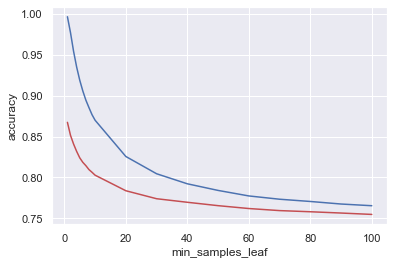

In [35]:
line1 = plt.plot(chosen_min_samples_leaf, train_scores, 'b', label='train accuracy')
line2 = plt.plot(chosen_min_samples_leaf, test_scores, 'r', label='test accuracy')
plt.ylabel('accuracy')
plt.xlabel('min_samples_leaf')
plt.show()

The train and test accuracy drops sharply once the minimum samples for leaf is restricted, but the overfit issue does not improve until test_scores is reduced to around 76% when min_samples_leaf = 60. <br>
This is a significant decrease in performance. Considering that the training dataset is consist of over 90,000 rows from more than 700 game rounds, it should be fairly representative of the actual games.I feel we should use the previous model without min_samples_leaf even if it has overfit issue. Its high validation accuracy should be able to generalize well.

In [36]:
models['random forest'] = forest_models['tuned']
pd.DataFrame(models)

,logistic,random forest
fit_time,0.55002 (+/- 0.016),35.78403 (+/- 0.361)
score_time,0.05904 (+/- 0.002),1.43878 (+/- 0.018)
test_precision,0.73981 (+/- 0.003),0.85390 (+/- 0.006)
train_precision,0.74049 (+/- 0.001),0.99603 (+/- 0.001)
test_recall,0.75394 (+/- 0.008),0.88004 (+/- 0.006)
train_recall,0.75413 (+/- 0.002),0.99670 (+/- 0.001)
test_f1,0.74678 (+/- 0.003),0.86674 (+/- 0.001)
train_f1,0.74725 (+/- 0.001),0.99637 (+/- 0.000)
test_accuracy,0.74945 (+/- 0.002),0.86738 (+/- 0.002)
train_accuracy,0.74998 (+/- 0.001),0.99644 (+/- 0.000)


### Neural Network <a name="5.3"></a>

In [37]:
neural_networks = {}

nn = make_pipeline(
    preprocessor, 
    MLPClassifier(
        hidden_layer_sizes=(10,),
        random_state=1
    )
)

neural_networks['default'] = mean_std_cross_val_scores(nn, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(neural_networks)

,default
fit_time,26.33822 (+/- 5.696)
score_time,0.05956 (+/- 0.002)
test_precision,0.73756 (+/- 0.006)
train_precision,0.74970 (+/- 0.004)
test_recall,0.79217 (+/- 0.016)
train_recall,0.80562 (+/- 0.012)
test_f1,0.76378 (+/- 0.005)
train_f1,0.77660 (+/- 0.003)
test_accuracy,0.75993 (+/- 0.002)
train_accuracy,0.77288 (+/- 0.001)


The neural network with 1 hidden layer and 10 units performs better than logistic regression. Let's see if increasing the units and layers improve its performance.

In [38]:
# param_grid = {
#     'mlpclassifier__hidden_layer_sizes': [(10,),(20,),(30,),(50,),(100,),(200,)],
#     'mlpclassifier__alpha': loguniform(1e-4, 0.05),
#     'mlpclassifier__learning_rate_init': loguniform(1e-4, 0.01),
# }

# random_search = RandomizedSearchCV(
#     nn,
#     param_grid,
#     n_iter=50,
#     verbose=2,
#     n_jobs=-1,
#     scoring='accuracy',
#     random_state=1,
#     return_train_score=True,
# )

# random_search.fit(X_train, y_train)

In [39]:
# random_search.best_params_

In [40]:
# nn_tuned = make_pipeline(
#     preprocessor, 
#     MLPClassifier(
#         hidden_layer_sizes=(200,),
#         alpha=0.0028778261702720282,
#         learning_rate_init=0.0011797576762829223,
#         max_iter=1000,
#         random_state=1
#     )
# )

# neural_networks['tuned'] = mean_std_cross_val_scores(nn_tuned, X_train, y_train, cv=5, return_train_score=True)
# pd.DataFrame(neural_networks)

In [41]:
# pickle.dump(neural_networks, open('neural_networks_metrics.sav', 'wb'))

In [42]:
neural_networks = pickle.load(open('neural_networks_metrics.sav', 'rb'))

In [43]:
pd.DataFrame(neural_networks)

,default,tuned
fit_time,19.70232 (+/- 4.196),136.50578 (+/- 3.672)
score_time,0.04907 (+/- 0.005),0.08477 (+/- 0.007)
test_precision,0.73756 (+/- 0.006),0.81809 (+/- 0.015)
train_precision,0.74970 (+/- 0.004),0.92735 (+/- 0.018)
test_recall,0.79217 (+/- 0.016),0.82539 (+/- 0.027)
train_recall,0.80562 (+/- 0.012),0.93400 (+/- 0.022)
test_f1,0.76378 (+/- 0.005),0.82130 (+/- 0.006)
train_f1,0.77660 (+/- 0.003),0.93031 (+/- 0.003)
test_accuracy,0.75993 (+/- 0.002),0.82412 (+/- 0.003)
train_accuracy,0.77288 (+/- 0.001),0.93146 (+/- 0.002)


Tuning improved neural network's accuracy to 82.4%. There is overfit issues too. <br>
It's possible that neural networks with more than 1 hidden layer could perform better even better. However, given the time and computation power constraint let's settle at this model for now.

In [44]:
models['neural network'] = neural_networks['tuned']
pd.DataFrame(models)

,logistic,random forest,neural network
fit_time,0.55002 (+/- 0.016),35.78403 (+/- 0.361),136.50578 (+/- 3.672)
score_time,0.05904 (+/- 0.002),1.43878 (+/- 0.018),0.08477 (+/- 0.007)
test_precision,0.73981 (+/- 0.003),0.85390 (+/- 0.006),0.81809 (+/- 0.015)
train_precision,0.74049 (+/- 0.001),0.99603 (+/- 0.001),0.92735 (+/- 0.018)
test_recall,0.75394 (+/- 0.008),0.88004 (+/- 0.006),0.82539 (+/- 0.027)
train_recall,0.75413 (+/- 0.002),0.99670 (+/- 0.001),0.93400 (+/- 0.022)
test_f1,0.74678 (+/- 0.003),0.86674 (+/- 0.001),0.82130 (+/- 0.006)
train_f1,0.74725 (+/- 0.001),0.99637 (+/- 0.000),0.93031 (+/- 0.003)
test_accuracy,0.74945 (+/- 0.002),0.86738 (+/- 0.002),0.82412 (+/- 0.003)
train_accuracy,0.74998 (+/- 0.001),0.99644 (+/- 0.000),0.93146 (+/- 0.002)


### Summary <a name="5.4"></a> 
I'll now compare the performance of each model against the test dataset.

In [45]:
final_models = {}

In [46]:
# logistic_final = make_pipeline(
#     preprocessor, 
#     LogisticRegression(max_iter=5000, random_state=1, C=0.001910974221528526, solver='lbfgs')
# )

# logistic_final.fit(X_train, y_train)

# pickle.dump(logistic_final, open('logistic_final.sav', 'wb'))

In [47]:
logistic_final = pickle.load(open('logistic_final.sav', 'rb'))

train_pred = logistic_final.predict(X_train)
test_pred = logistic_final.predict(X_test)

logistic_metrics = {
    'train accuracy' : accuracy_score(y_train,train_pred),
    'test accuracy' : accuracy_score(y_test,test_pred),
    'train f1' : f1_score(y_train,train_pred),
    'test f1' : f1_score(y_test,test_pred),
    'train recall' : recall_score(y_train,train_pred),
    'test recall' : recall_score(y_test,test_pred),
    'train precision' : precision_score(y_train,train_pred),
    'test precision' : precision_score(y_test,test_pred),
}

final_models['logistic regression'] = logistic_metrics

In [48]:
# rf_final = make_pipeline(
#     preprocessor, 
#     RandomForestClassifier(
#         criterion='entropy',
#         max_depth=29,
#         max_features='log2',
#         n_estimators=288,
#         random_state=1
#     )
# )

# rf_final.fit(X_train, y_train)

# pickle.dump(rf_final, open('rf_final.sav', 'wb'))

In [49]:
rf_final = pickle.load(open('rf_final.sav', 'rb'))

train_pred = rf_final.predict(X_train)
test_pred = rf_final.predict(X_test)

rf_metrics = {
    'train accuracy' : accuracy_score(y_train,train_pred),
    'test accuracy' : accuracy_score(y_test,test_pred),
    'train f1' : f1_score(y_train,train_pred),
    'test f1' : f1_score(y_test,test_pred),
    'train recall' : recall_score(y_train,train_pred),
    'test recall' : recall_score(y_test,test_pred),
    'train precision' : precision_score(y_train,train_pred),
    'test precision' : precision_score(y_test,test_pred),
}

final_models['random forest'] = rf_metrics

In [50]:
# nn_final = make_pipeline(
#     preprocessor, 
#     MLPClassifier(
#         hidden_layer_sizes=(200,),
#         alpha=0.0028778261702720282,
#         learning_rate_init=0.0011797576762829223,
#         max_iter=1000,
#         random_state=1
#     )
# )

# nn_final.fit(X_train, y_train)

# pickle.dump(nn_final, open('nn_final.sav', 'wb'))

In [51]:
nn_final = pickle.load(open('nn_final.sav', 'rb'))

train_pred = nn_final.predict(X_train)
test_pred = nn_final.predict(X_test)

nn_metrics = {
    'train accuracy' : accuracy_score(y_train,train_pred),
    'test accuracy' : accuracy_score(y_test,test_pred),
    'train f1' : f1_score(y_train,train_pred),
    'test f1' : f1_score(y_test,test_pred),
    'train recall' : recall_score(y_train,train_pred),
    'test recall' : recall_score(y_test,test_pred),
    'train precision' : precision_score(y_train,train_pred),
    'test precision' : precision_score(y_test,test_pred),
}

final_models['neural network'] = nn_metrics

In [52]:
pd.DataFrame(final_models, index=['train accuracy', 'test accuracy', 'train f1', 'test f1', 'train recall', 'test recall', 'train precision','test precision'])

,logistic regression,random forest,neural network
train accuracy,0.750092,0.996069,0.917337
test accuracy,0.753656,0.881546,0.833143
train f1,0.747443,0.995989,0.915394
test f1,0.751657,0.881011,0.829785
train recall,0.754584,0.995958,0.912485
test recall,0.759824,0.893773,0.828921
train precision,0.740436,0.996020,0.918322
test precision,0.743665,0.868608,0.830650


Out of the 3 models, random forest performs the best with the highest test score in all 4 metrics. <br>
The shadow neural networks performance is better than that of logistic regression. <br>
Both random forest and neural network have overfit issue.

## Dimension Reduction with PCA  <a name="6"></a>
The complete dataset has 96 attributes, 80 of them are weaponry-related. When dealing with high dimensional data, models would have long execution time. Some models might suffer from "the curse of dimensionality" when dealing with high dimensional data. I will now apply PCA and Kernel PCA on the weaponry-related features to reduce the dataset into smaller dimension. 

### PCA  <a name="6.1"></a>

Drop the columns that is always 0. Since columns have similar range, no standardization is needed.

In [53]:
empty_columns = ['ct_weapon_bizon', 'ct_weapon_g3sg1', 't_weapon_m249', 'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff']

dataset_weaponry = dataset.drop(columns=non_weaponry_columns)
dataset_weaponry = dataset_weaponry.drop(columns=empty_columns)

dataset_weaponry

,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
122406,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122407,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0
122408,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0

We can observe that weaponry data is very sparse.

In [54]:
pca = PCA()
pca.fit(dataset_weaponry)

PCA()

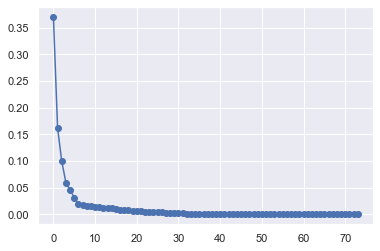

In [55]:
plt.plot(pca.explained_variance_ratio_, '-o')

In [56]:
total_explained = 0
for i in range(20):
    total_explained = total_explained + pca.explained_variance_ratio_[i]

total_explained

0.941111557399338

With the first 20 components we can capture 94.1% of the variations in the weaponry columns. 

<AxesSubplot:>

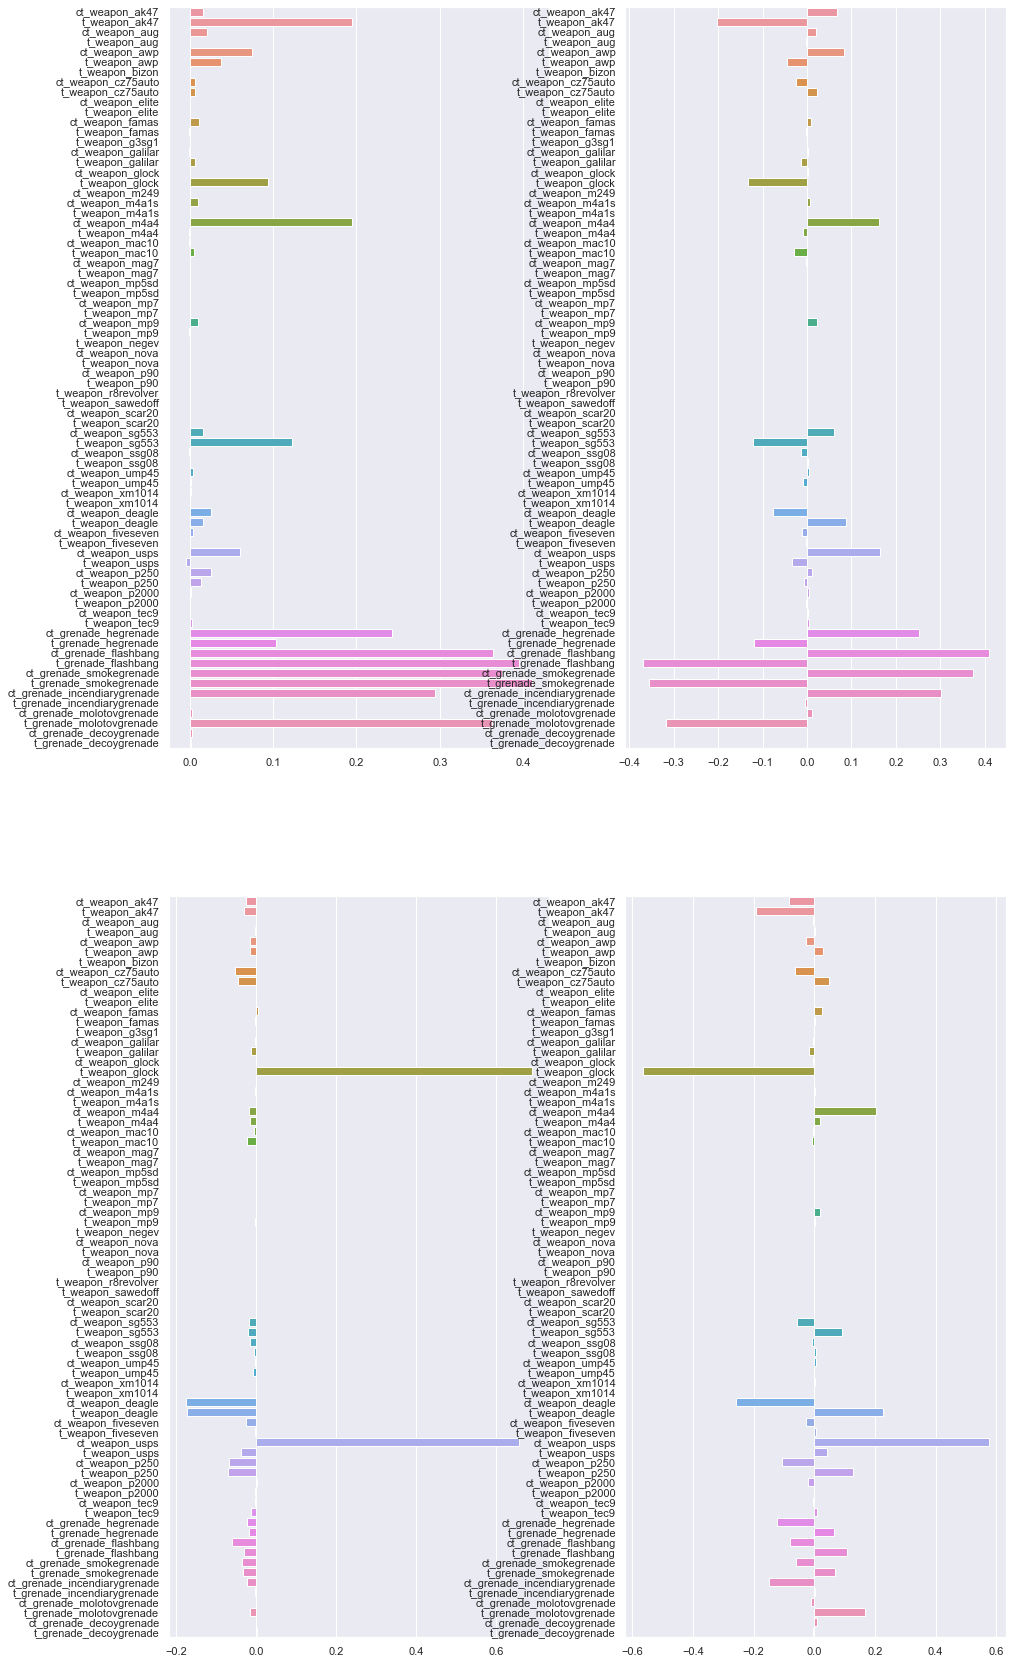

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(15, 30))
sns.barplot(x=pca.components_[0], y=dataset_weaponry.columns, orient='h', ax=ax[0,0])
sns.barplot(x=pca.components_[1], y=dataset_weaponry.columns, orient='h', ax=ax[0,1])
sns.barplot(x=pca.components_[2], y=dataset_weaponry.columns, orient='h', ax=ax[1,0])
sns.barplot(x=pca.components_[3], y=dataset_weaponry.columns, orient='h', ax=ax[1,1])

The first 4 components are dominated by ak47, m4, various grenades, glock, usp. This is reasonable because they are usually the most frequently used weaponry in CSGO games.

In [58]:
pca=PCA(n_components=20)
weaponrny_pca = pca.fit_transform(dataset_weaponry)
weaponrny_pca = pd.DataFrame(weaponrny_pca)
weaponrny_pca = weaponrny_pca.set_axis(['v1', 'v2', 'v3', 'v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20'], axis=1, inplace=False)

weaponrny_pca

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
0,-4.148640,-0.083645,2.353800,-0.566881,0.268318,-0.453753,0.347483,0.190072,-0.239594,-0.002555,-0.049786,0.099948,-0.189495,0.133103,0.399167,0.241925,0.041434,0.224289,-0.081052,-0.362892
1,-3.326892,-0.795605,2.287446,-0.427903,0.335171,-0.817296,0.423819,0.937348,0.472201,-0.950063,-0.692089,-0.137739,-0.258910,0.003485,0.659942,0.055522,0.108409,0.389369,-0.034268,-0.473087
2,-3.422623,-0.667902,1.594085,0.157972,0.186988,-0.915048,0.395633,0.842484,0.508441,-1.028482,-0.763322,-0.260793,-0.189880,-0.106428,0.365719,-0.034595,0.061592,0.128927,0.049692,-0.090102
3,-4.338664,0.174653,0.967363,0.584628,-0.014901,-0.635302,0.328782,0.000528,-0.189730,-0.162481,-0.163710,-0.155923,-0.064131,-0.037502,-0.024520,0.149226,-0.014307,-0.195244,0.049579,0.006279
4,-4.148640,-0.083645,2.353800,-0.566881,0.268318,-0.453753,0.347483,0.190072,-0.239594,-0.002555,-0.049786,0.099948,-0.189495,0.133103,0.399167,0.241925,0.041434,0.224289,-0.081052,-0.362892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,-1.902130,-0.651736,-1.467333,0.646504,0.715523,0.837328,0.163860,-0.725198,1.077450,-0.055091,0.816305,-0.881380,0.599544,-0.437732,-0.613921,0.535469,0.216391,1.353175,-0.141582,-0.053002
122406,-2.206043,0.112100,2.805078,0.430451,0.777430,0.457405,-0.131054,-0.036362,0.399548,1.063330,0.814521,-0.402111,-0.173171,0.020199,0.055267,-0.120366,0.128033,0.247185,-0.038017,-0.118593
122407,5.234404,-2.304856,-1.947291,-1.656893,0.543973,-0.564953,-1.203627,1.679106,-0.999920,0.327190,-0.421715,0.767640,-0.146838,-1.713823,0.636066,0.573582,-0.123303,0.323627,-0.061788,-0.581418
122408,2.057352,-4.411293,-1.609561,-1.195425,1.015138,0.062203,-0.173952,0.005306,-0.346083,2.386945,-0.661174,1.265442,0.080129,-1.625527,0.202092,-0.099718,-0.117939,0.069889,-0.140127,-0.343191


### Truncated SVD <a name="6.2"></a>
As we observed earlier weaponry data is a sparse matrix. We can consider use truncated svd for the compression because svd does not center the data before computing so that it can work with sparse matrices efficiently.

In [59]:
svd = TruncatedSVD(n_components=50)
svd.fit(dataset_weaponry)

TruncatedSVD(n_components=50)

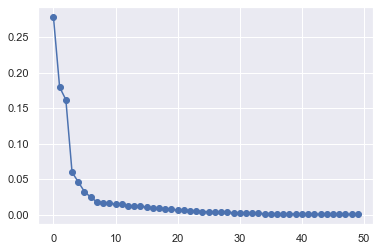

In [60]:
plt.plot(svd.explained_variance_ratio_, '-o')

In [61]:
total_explained = 0
for i in range(20):
    total_explained = total_explained + svd.explained_variance_ratio_[i]

total_explained

0.9399148280943384

The variance captured by the first 20 component is slightly less than that of pca.

In [62]:
svd = TruncatedSVD(n_components=20)

weaponrny_svd = svd.fit_transform(dataset_weaponry)
weaponrny_svd = pd.DataFrame(weaponrny_svd)
weaponrny_svd = weaponrny_svd.set_axis(['v1', 'v2', 'v3', 'v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20'], axis=1, inplace=False)

weaponrny_svd

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
0,4.079387,-4.830340,-0.303429,-0.573879,0.313597,-0.590990,-0.258493,0.245354,0.257815,-0.108896,-0.034184,-0.083868,-0.126138,0.329603,-0.284501,0.020550,0.230278,0.214897,-0.052193,-0.172979
1,4.660926,-4.233642,-0.992990,-0.435741,0.392000,-0.982837,-0.248215,0.738525,0.325345,1.235132,-0.613698,-0.281315,-0.242548,0.234432,-0.460678,-0.273103,0.250238,0.337059,0.037616,-0.355310
2,4.177037,-3.692817,-0.831104,0.153088,0.226069,-1.017685,-0.152488,0.661158,0.254097,1.291831,-0.678972,-0.287399,-0.232125,-0.020949,-0.257356,-0.211664,0.046637,0.118775,0.092154,-0.201404
3,3.134400,-3.765450,0.022417,0.583656,-0.006645,-0.640241,-0.069103,0.111030,0.126676,-0.012643,-0.136276,-0.088516,-0.108240,-0.085976,0.034993,0.105747,-0.065928,-0.099270,0.031241,0.031409
4,4.079387,-4.830340,-0.303429,-0.573879,0.313597,-0.590990,-0.258493,0.245354,0.257815,-0.108896,-0.034184,-0.083868,-0.126138,0.329603,-0.284501,0.020550,0.230278,0.214897,-0.052193,-0.172979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,4.083853,-0.578266,-0.644893,0.656740,0.625446,1.156153,0.315173,0.035221,-1.285863,0.295996,0.733225,0.603360,0.304581,-1.012373,0.583343,0.191346,1.048996,1.104466,-0.062779,-0.195585
122406,6.067040,-4.259702,-0.099885,0.421217,0.825789,0.311156,-0.154984,0.121257,-0.397840,-0.445763,0.563918,1.146670,-0.168432,0.099190,-0.092291,-0.009420,-0.078192,0.152796,0.062489,-0.427423
122407,9.798806,3.788385,-2.139527,-1.649009,0.479173,-0.086760,1.563055,0.122193,1.867486,-0.042825,-0.441355,-0.132406,0.065403,-0.718929,-1.842359,0.736713,0.173737,0.011998,0.106808,-0.790519
122408,7.479251,1.725052,-4.326762,-1.185483,0.918838,0.659479,1.526036,0.565016,-0.167475,-2.244923,-0.793921,-0.010497,0.337417,-0.793941,-1.461329,0.388979,-0.197213,-0.223937,-0.002797,-0.618823


### Comparison <a name="6.3"></a> 
Apart from variance explained, let's evaluate the result after dimension reduction with logistic regression.

In [63]:
dataset_pca = pd.concat([dataset_non_weaponry, weaponrny_pca], axis=1)

dataset_svd = pd.concat([dataset_non_weaponry, weaponrny_svd], axis=1)

In [64]:
y_pca = dataset_pca[['round_winner']]
y_pca = y_pca.replace({'CT':1, 'T': 0})
y_pca = y_pca.values.ravel()

X_pca = dataset_pca.drop(columns='round_winner')

# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=1)

X_pca.shape

(122410, 36)

In [65]:
y_svd = dataset_svd[['round_winner']]
y_svd = y_svd.replace({'CT':1, 'T': 0})
y_svd = y_svd.values.ravel()

X_svd = dataset_svd.drop(columns='round_winner')

X_svd.shape

(122410, 36)

In [66]:
drop_features_pca = ['ct_players_alive', 't_players_alive']

numeric_features_pca = []
for col in X_pca.columns:
    if col in set(X_pca.columns) - set(drop_features) - set(binary_features) - set(nominal_features):
        numeric_features_pca.append(col)

preprocessor_pca = make_column_transformer(
    ("drop", drop_features_pca),
    (StandardScaler(), numeric_features_pca),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), nominal_features),
) 

In [67]:
drop_features_svd = ['ct_players_alive', 't_players_alive']

numeric_features_svd = []
for col in X_svd.columns:
    if col in set(X_svd.columns) - set(drop_features) - set(binary_features) - set(nominal_features):
        numeric_features_svd.append(col)

preprocessor_svd = make_column_transformer(
    ("drop", drop_features_svd),
    (StandardScaler(), numeric_features_svd),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), nominal_features),
) 

In [68]:
dimension_reduction = {}
dimension_reduction['complete data'] = logistic['default']

In [69]:
lr_pca = make_pipeline(
    preprocessor_pca, 
    LogisticRegression(max_iter=5000, random_state=1, C=0.001910974221528526, solver='lbfgs')
)

dimension_reduction['pca'] = mean_std_cross_val_scores(lr_pca, X_pca, y_pca, cv=5, return_train_score=True)

In [70]:
lr_svd = make_pipeline(
    preprocessor_svd, 
    LogisticRegression(max_iter=5000, random_state=1, C=0.001910974221528526, solver='lbfgs')
)

dimension_reduction['svd'] = mean_std_cross_val_scores(lr_svd, X_svd, y_svd, cv=5, return_train_score=True)

In [71]:
pd.DataFrame(dimension_reduction)

,complete data,pca,svd
fit_time,1.08777 (+/- 0.030),0.38810 (+/- 0.017),0.39305 (+/- 0.017)
score_time,0.05884 (+/- 0.002),0.04829 (+/- 0.005),0.04891 (+/- 0.003)
test_precision,0.73770 (+/- 0.002),0.74007 (+/- 0.009),0.73923 (+/- 0.009)
train_precision,0.73903 (+/- 0.001),0.74223 (+/- 0.001),0.74174 (+/- 0.001)
test_recall,0.75425 (+/- 0.007),0.74443 (+/- 0.003),0.74568 (+/- 0.002)
train_recall,0.75480 (+/- 0.001),0.74629 (+/- 0.002),0.74778 (+/- 0.003)
test_f1,0.74586 (+/- 0.003),0.74222 (+/- 0.004),0.74242 (+/- 0.005)
train_f1,0.74683 (+/- 0.000),0.74426 (+/- 0.001),0.74475 (+/- 0.002)
test_accuracy,0.74812 (+/- 0.002),0.74650 (+/- 0.005),0.74634 (+/- 0.006)
train_accuracy,0.74921 (+/- 0.001),0.74859 (+/- 0.001),0.74874 (+/- 0.001)


It can be observe that the fitting time is reduced to around 1/3 while the performance only slightly decreased. This means the dimension reduction is effective. <br>
The performance of models with PCA and SVD are similar. PCA performs slightly better but also slightly slower. <br>
Therefore, both algorithm can be used in our case.

## Conclusion  <a name="7"></a>

In this project, I trained 3 supervised learning models to predict CS:GO round winner with game snapshot records. Among them, random forest performs the best and achieved a test accuracy of 86.9% It has overfit issue, but considering that the dataset is large and representative and that the test scores are high, the model should be able to generalize reasonably well.

As for dimension reduction, both PCA and truncated SVD can capture around 94% of the variance withthe first 20 components. When put into logistic regression, the 2 algorithm reduced the fit time to 1/3 without significant degrade the model's performance.